In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!nvidia-smi

Sun May  3 16:44:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sn
import torch.nn.functional as F
import sklearn.metrics as skmt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading Dataset

In [0]:
!mkdir './data/'
!unzip "/content/drive/My Drive/DeepAssignment/Assignment05/part2/A_05_Part_02_Dataset.zip" -d "./data/"

Streaming output truncated to the last 5000 lines.
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: ./data/A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b21

In [0]:
data_dir = './data/A_05_Part_02_Dataset/'

In [0]:
!rm -r ./data/A_05_Part_02_Dataset/Train/.ipynb_checkpoints

rm: cannot remove './data/A_05_Part_02_Dataset/Train/.ipynb_checkpoints': No such file or directory


In [0]:
class ImageFolderHotEncoded(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderHotEncoded, self).__getitem__(index)
        label = original_tuple[1]
        if self.classes[label] == 'normal':
            alabel = torch.LongTensor([0, 0, 1])
        elif self.classes[label] == 'covid':
            alabel = torch.LongTensor([1, 1, 0])
        elif self.classes[label] == 'covid-19':
            alabel = torch.LongTensor([1, 1, 0])
        elif self.classes[label] == 'pneumonia':
            alabel = torch.LongTensor([0, 1, 0])
        #print(original_tuple[0].shape, self.imgs[index])
        return original_tuple[0], alabel

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = ImageFolderHotEncoded(data_dir + '/Train', transform=train_transforms)
val_data = ImageFolderHotEncoded(data_dir + '/Validation', transform=test_transforms)


trainloader      = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


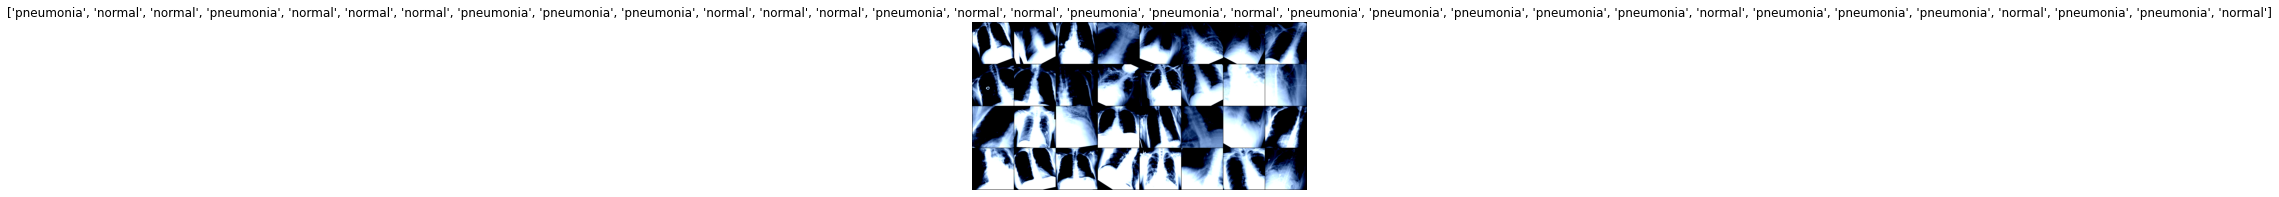

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

inputs, classes = next(iter(trainloader))
show_databatch(inputs, torch.argmax(classes, axis=1))

## Helper

In [0]:
def compute_acc_and_loss(model, criterion, loader):
    model.eval()
    actual_labels = []
    predic_labels = []

    with torch.no_grad():
        for data in loader:
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            labels = labels.type_as(outputs)
            actual_labels.extend(labels)
            predic_labels.extend(outputs)
    actual_labels = torch.stack(actual_labels)
    predic_labels = torch.stack(predic_labels)

    loss = criterion(predic_labels, actual_labels)
    acc = skmt.jaccard_score(actual_labels.cpu().numpy(), torch.round(torch.sigmoid(predic_labels)).cpu().numpy(), average = 'samples')
    return acc*100, loss.item()

In [0]:
def print_statistics(model, loader):
    model.eval()
    actual_labels = []
    predic_labels = []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            actual_labels.extend(labels)
            predic_labels.extend(outputs)

    actual_labels = torch.stack(actual_labels).cpu().numpy()
    predic_labels = torch.round(torch.sigmoid(torch.stack(predic_labels))).cpu().numpy()

    conf  = skmt.multilabel_confusion_matrix(actual_labels, predic_labels)
    precesion = skmt.precision_score(actual_labels, predic_labels, average = 'samples')
    recall = skmt.recall_score(actual_labels, predic_labels, average = 'samples')
    f1_score = skmt.f1_score(actual_labels, predic_labels, average = 'samples')
    accuracy = skmt.jaccard_score(actual_labels, predic_labels, average = 'samples')
    
    print(' Accuracy : %.2f %%' %(accuracy) )
    print(' F1 Score : %.2f %%' %(f1_score))
    print(' Precesion : %.2f %%' %(precesion))
    print(' Recall : %.2f %%' %(recall))

    df_cm = pd.DataFrame(conf[0].astype(int), columns=['not covid', 'covid'], index = ['not covid', 'covid'])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (4,4))
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt="d")
    plt.show()

    df_cm = pd.DataFrame(conf[1].astype(int), columns=['not pneumonia', 'pneumonia',], index = ['not pneumonia', 'pneumonia',])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (4,4))
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt="d")
    plt.show()

    df_cm = pd.DataFrame(conf[2].astype(int), columns=['not normal', 'normal'], index = ['not normal', 'normal'])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (4,4))
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt="d")
    plt.show()

## Focal Loss

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction= 'sum'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        p = torch.sigmoid(inputs)
        y = targets
        alpha = self.alpha
        gamma = self.gamma
        if self.reduction == 'mean':
            return -torch.mean(y*alpha*(1-p)**gamma*torch.log(p) + (1-y)*(1-alpha)*(p)**gamma*torch.log(1-p))
        elif self.reduction == 'sum':
            return -torch.sum(y*alpha*(1-p)**gamma*torch.log(p) + (1-y)*(1-alpha)*(p)**gamma*torch.log(1-p))
        else:
            return  -1* (y*alpha*(1-p)**gamma*torch.log(p) + (1-y)*(1-alpha)*(p)**gamma*torch.log(1-p))

## Task1 VGG16 (BCE Loss)

In [0]:
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=3, bias=True)
name = 'vgg16'
out_dir = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task1/' + name
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 25
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [0]:
from tqdm import tqdm


train_loss = np.zeros(Epochs+1)
valid_loss = np.zeros(Epochs+1)

train_acc = np.zeros(Epochs+1)
valid_acc = np.zeros(Epochs+1)

train_acc[0], train_loss[0] = compute_acc_and_loss(model, criterion, trainloader)
valid_acc[0], valid_loss[0] = compute_acc_and_loss(model, criterion, validationloader)

for epoch in range(Epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)] \t\
             Loss:{:.6f}  \
             Acc:{:.2f}   \
             RunningLoss:{:.6f}   \
             RunningAcc:{:.2f}'.format(
             epoch, i * len(inputs), len(trainloader.dataset),
             100. * i / len(trainloader),
             loss.item(),
             acc.item(),
             running_loss/(i+1),
             running_acc/(i+1)))
    train_acc[epoch+1], train_loss[epoch+1] = compute_acc_and_loss(model, criterion, trainloader)
    valid_acc[epoch+1], valid_loss[epoch+1] = compute_acc_and_loss(model, criterion, validationloader)
    print('Train Epoch: {}  Train Accuracy: {:.2f} Train Loss : {:.6f} \
                            Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            train_acc[epoch+1], train_loss[epoch+1], 
                            valid_acc[epoch+1], valid_loss[epoch+1]))
    torch.save(model.state_dict(), out_dir + '/ft_' + str(epoch) +  '.pth')

print('Finished Training')


Train Epoch: 0 [4632/6200 (99%)] 	             Loss:0.366460               Acc:0.79                RunningLoss:0.460045                RunningAcc:0.63: : 194it [03:06,  1.04it/s]


Train Epoch: 0  Train Accuracy: 77.70 Train Loss : 0.375920                             Validation Accuracy: 79.43  Validation Loss : 0.362635 


Train Epoch: 1 [4632/6200 (99%)] 	             Loss:0.251917               Acc:0.88                RunningLoss:0.340214                RunningAcc:0.77: : 194it [03:05,  1.05it/s]


Train Epoch: 1  Train Accuracy: 83.73 Train Loss : 0.297283                             Validation Accuracy: 85.54  Validation Loss : 0.294296 


Train Epoch: 2 [4632/6200 (99%)] 	             Loss:0.318504               Acc:0.73                RunningLoss:0.289101                RunningAcc:0.82: : 194it [03:04,  1.05it/s]


Train Epoch: 2  Train Accuracy: 85.58 Train Loss : 0.261105                             Validation Accuracy: 87.45  Validation Loss : 0.265315 


Train Epoch: 3 [4632/6200 (99%)] 	             Loss:0.346134               Acc:0.81                RunningLoss:0.270962                RunningAcc:0.84: : 194it [03:04,  1.05it/s]


Train Epoch: 3  Train Accuracy: 86.56 Train Loss : 0.245666                             Validation Accuracy: 87.15  Validation Loss : 0.257968 


Train Epoch: 4 [4632/6200 (99%)] 	             Loss:0.495070               Acc:0.73                RunningLoss:0.253512                RunningAcc:0.85: : 194it [03:05,  1.05it/s]


Train Epoch: 4  Train Accuracy: 87.42 Train Loss : 0.228629                             Validation Accuracy: 89.41  Validation Loss : 0.234868 


Train Epoch: 5 [4632/6200 (99%)] 	             Loss:0.246559               Acc:0.85                RunningLoss:0.235299                RunningAcc:0.86: : 194it [03:06,  1.04it/s]


Train Epoch: 5  Train Accuracy: 87.59 Train Loss : 0.219493                             Validation Accuracy: 88.22  Validation Loss : 0.225221 


Train Epoch: 6 [4632/6200 (99%)] 	             Loss:0.285584               Acc:0.85                RunningLoss:0.222040                RunningAcc:0.87: : 194it [03:06,  1.04it/s]


Train Epoch: 6  Train Accuracy: 87.88 Train Loss : 0.203895                             Validation Accuracy: 89.89  Validation Loss : 0.217151 


Train Epoch: 7 [4632/6200 (99%)] 	             Loss:0.156961               Acc:0.96                RunningLoss:0.223005                RunningAcc:0.87: : 194it [03:24,  1.05s/it]


Train Epoch: 7  Train Accuracy: 88.47 Train Loss : 0.209045                             Validation Accuracy: 90.34  Validation Loss : 0.217073 


Train Epoch: 8 [4632/6200 (99%)] 	             Loss:0.180302               Acc:0.88                RunningLoss:0.211619                RunningAcc:0.87: : 194it [03:22,  1.04s/it]


Train Epoch: 8  Train Accuracy: 88.53 Train Loss : 0.200198                             Validation Accuracy: 90.13  Validation Loss : 0.213385 


Train Epoch: 9 [4632/6200 (99%)] 	             Loss:0.228478               Acc:0.94                RunningLoss:0.206805                RunningAcc:0.88: : 194it [03:25,  1.06s/it]


Train Epoch: 9  Train Accuracy: 89.00 Train Loss : 0.195803                             Validation Accuracy: 90.76  Validation Loss : 0.205095 


Train Epoch: 10 [4632/6200 (99%)] 	             Loss:0.164976               Acc:0.96                RunningLoss:0.208996                RunningAcc:0.87: : 194it [03:22,  1.04s/it]


Train Epoch: 10  Train Accuracy: 89.23 Train Loss : 0.187141                             Validation Accuracy: 90.05  Validation Loss : 0.200998 


Train Epoch: 11 [4632/6200 (99%)] 	             Loss:0.263200               Acc:0.85                RunningLoss:0.203374                RunningAcc:0.88: : 194it [03:14,  1.00s/it]


Train Epoch: 11  Train Accuracy: 89.57 Train Loss : 0.185600                             Validation Accuracy: 90.53  Validation Loss : 0.200159 


Train Epoch: 12 [4632/6200 (99%)] 	             Loss:0.121399               Acc:0.90                RunningLoss:0.190846                RunningAcc:0.89: : 194it [03:07,  1.03it/s]


Train Epoch: 12  Train Accuracy: 89.17 Train Loss : 0.190362                             Validation Accuracy: 90.05  Validation Loss : 0.198846 


Train Epoch: 13 [4632/6200 (99%)] 	             Loss:0.178396               Acc:0.83                RunningLoss:0.197625                RunningAcc:0.89: : 194it [03:06,  1.04it/s]


Train Epoch: 13  Train Accuracy: 89.72 Train Loss : 0.185230                             Validation Accuracy: 90.92  Validation Loss : 0.190837 


Train Epoch: 14 [4632/6200 (99%)] 	             Loss:0.256518               Acc:0.83                RunningLoss:0.196631                RunningAcc:0.89: : 194it [03:10,  1.02it/s]


Train Epoch: 14  Train Accuracy: 89.39 Train Loss : 0.182054                             Validation Accuracy: 90.68  Validation Loss : 0.193166 


Train Epoch: 15 [4632/6200 (99%)] 	             Loss:0.113619               Acc:0.94                RunningLoss:0.195852                RunningAcc:0.89: : 194it [03:24,  1.05s/it]


Train Epoch: 15  Train Accuracy: 89.94 Train Loss : 0.179430                             Validation Accuracy: 90.84  Validation Loss : 0.183875 


Train Epoch: 16 [4632/6200 (99%)] 	             Loss:0.276907               Acc:0.81                RunningLoss:0.187924                RunningAcc:0.89: : 194it [03:25,  1.06s/it]


Train Epoch: 16  Train Accuracy: 89.96 Train Loss : 0.175318                             Validation Accuracy: 91.16  Validation Loss : 0.181956 


Train Epoch: 17 [4632/6200 (99%)] 	             Loss:0.181953               Acc:0.90                RunningLoss:0.183650                RunningAcc:0.89: : 194it [03:27,  1.07s/it]


Train Epoch: 17  Train Accuracy: 89.52 Train Loss : 0.178102                             Validation Accuracy: 90.13  Validation Loss : 0.182463 


Train Epoch: 18 [4632/6200 (99%)] 	             Loss:0.136236               Acc:0.94                RunningLoss:0.188813                RunningAcc:0.89: : 194it [03:30,  1.09s/it]


Train Epoch: 18  Train Accuracy: 90.84 Train Loss : 0.166525                             Validation Accuracy: 91.40  Validation Loss : 0.177823 


Train Epoch: 19 [4632/6200 (99%)] 	             Loss:0.113082               Acc:0.96                RunningLoss:0.177095                RunningAcc:0.90: : 194it [03:28,  1.07s/it]


Train Epoch: 19  Train Accuracy: 90.51 Train Loss : 0.168168                             Validation Accuracy: 91.48  Validation Loss : 0.180226 


Train Epoch: 20 [4632/6200 (99%)] 	             Loss:0.167926               Acc:0.92                RunningLoss:0.184251                RunningAcc:0.89: : 194it [03:11,  1.01it/s]


Train Epoch: 20  Train Accuracy: 90.20 Train Loss : 0.172827                             Validation Accuracy: 91.40  Validation Loss : 0.173222 


Train Epoch: 21 [4632/6200 (99%)] 	             Loss:0.254168               Acc:0.94                RunningLoss:0.178685                RunningAcc:0.89: : 194it [03:10,  1.02it/s]


Train Epoch: 21  Train Accuracy: 90.99 Train Loss : 0.168290                             Validation Accuracy: 92.20  Validation Loss : 0.175898 


Train Epoch: 22 [4632/6200 (99%)] 	             Loss:0.114787               Acc:0.92                RunningLoss:0.175769                RunningAcc:0.90: : 194it [03:07,  1.04it/s]


Train Epoch: 22  Train Accuracy: 90.43 Train Loss : 0.168684                             Validation Accuracy: 91.56  Validation Loss : 0.171064 


Train Epoch: 23 [4632/6200 (99%)] 	             Loss:0.231855               Acc:0.88                RunningLoss:0.176389                RunningAcc:0.90: : 194it [03:05,  1.04it/s]


Train Epoch: 23  Train Accuracy: 89.63 Train Loss : 0.182511                             Validation Accuracy: 90.02  Validation Loss : 0.175706 


Train Epoch: 24 [4632/6200 (99%)] 	             Loss:0.160444               Acc:0.88                RunningLoss:0.179894                RunningAcc:0.90: : 194it [03:04,  1.05it/s]


Train Epoch: 24  Train Accuracy: 90.77 Train Loss : 0.168458                             Validation Accuracy: 91.88  Validation Loss : 0.168327 
Finished Training


### visualize

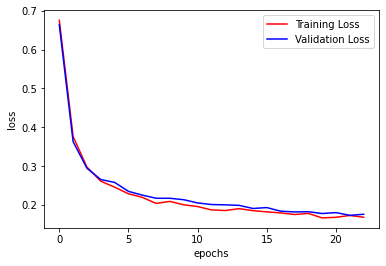

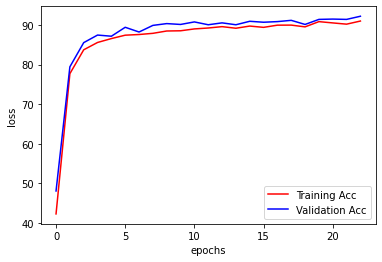

validation accuracy :  21 92.19745222929936
loaded
Training Dataset: 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Accuracy : 0.91 %
 F1 Score : 0.91 %
 Precesion : 0.92 %
 Recall : 0.91 %


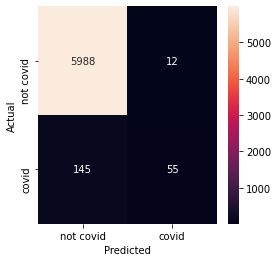

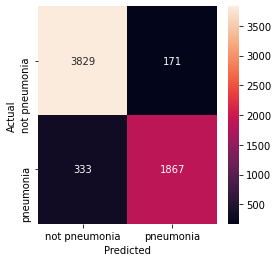

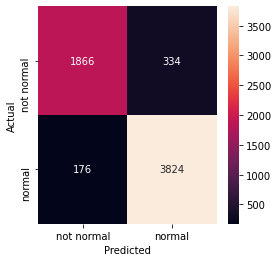

Validation Dataset: 
 Accuracy : 0.92 %
 F1 Score : 0.93 %
 Precesion : 0.93 %
 Recall : 0.92 %


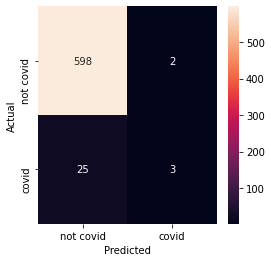

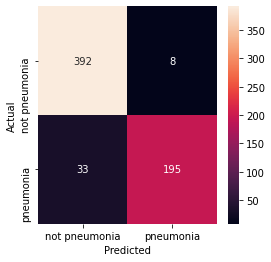

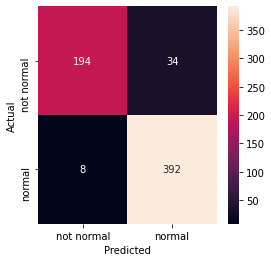

In [0]:
best_model = np.argmax(valid_acc)
r = best_model+1

plt.figure()
plt.plot(np.arange(r), train_loss[:r], 'r', np.arange(r), valid_loss[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
plt.figure()
plt.plot(np.arange(r), train_acc[:r], 'r', np.arange(r), valid_acc[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Acc', 'Validation Acc'])
plt.show()

print('validation accuracy : ', best_model-1, valid_acc[best_model])

weights_path = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task1/' + name + '/ft_' + str(best_model-1) + '.pth'
model.load_state_dict(torch.load(weights_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('loaded')

print('Training Dataset: ')
print_statistics(model, trainloader)
print('Validation Dataset: ')
print_statistics(model, validationloader)

## Task1 ResNet (BCE Loss)

In [0]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
name = 'resnet18'
out_dir = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task1/' + name
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

### Training

In [0]:
Epochs = 25
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [0]:
from tqdm import tqdm


train_loss = np.zeros(Epochs+1)
valid_loss = np.zeros(Epochs+1)

train_acc = np.zeros(Epochs+1)
valid_acc = np.zeros(Epochs+1)

train_acc[0], train_loss[0] = compute_acc_and_loss(model, criterion, trainloader)
valid_acc[0], valid_loss[0] = compute_acc_and_loss(model, criterion, validationloader)

for epoch in range(Epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)] \t\
             Loss:{:.6f}  \
             Acc:{:.2f}   \
             RunningLoss:{:.6f}   \
             RunningAcc:{:.2f}'.format(
             epoch, i * len(inputs), len(trainloader.dataset),
             100. * i / len(trainloader),
             loss.item(),
             acc.item(),
             running_loss/(i+1),
             running_acc/(i+1)))
    train_acc[epoch+1], train_loss[epoch+1] = compute_acc_and_loss(model, criterion, trainloader)
    valid_acc[epoch+1], valid_loss[epoch+1] = compute_acc_and_loss(model, criterion, validationloader)
    print('Train Epoch: {}  Train Accuracy: {:.2f} Train Loss : {:.6f} \
                            Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            train_acc[epoch+1], train_loss[epoch+1], 
                            valid_acc[epoch+1], valid_loss[epoch+1]))
    torch.save(model.state_dict(), out_dir + '/ft_' + str(epoch) +  '.pth')

print('Finished Training')


### visualize

loaded
Training Dataset: 
 Accuracy : 0.89 %
 F1 Score : 0.90 %
 Precesion : 0.90 %
 Recall : 0.89 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


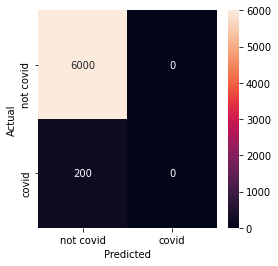

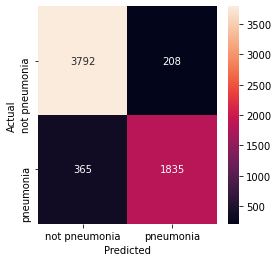

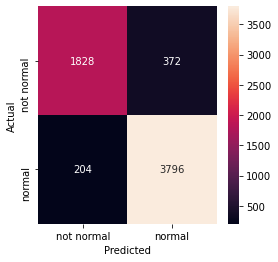

Validation Dataset: 
 Accuracy : 0.90 %
 F1 Score : 0.90 %
 Precesion : 0.91 %
 Recall : 0.90 %


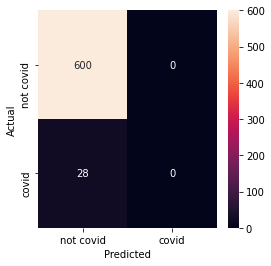

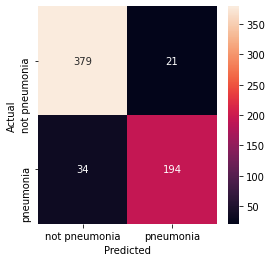

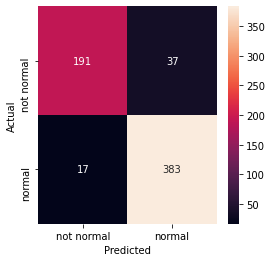

In [0]:
best_model = np.argmax(valid_acc)
r = best_model+1

plt.figure()
plt.plot(np.arange(r), train_loss[:r], 'r', np.arange(r), valid_loss[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
plt.figure()
plt.plot(np.arange(r), train_acc[:r], 'r', np.arange(r), valid_acc[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Acc', 'Validation Acc'])
plt.show()

print(best_model-1, valid_acc[best_model])

weights_path = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task1/' + name + '/ft_' + str(best_model-1) + '.pth'
model.load_state_dict(torch.load(weights_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('loaded')

print('Training Dataset: ')
print_statistics(model, trainloader)
print('Validation Dataset: ')
print_statistics(model, validationloader)

## Task2 VGG16 (Focal Loss)

In [0]:
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=3, bias=True)
name = 'vgg16'
out_dir = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task2/' + name
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 25
criterion = FocalLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [0]:
from tqdm import tqdm


train_loss = np.zeros(Epochs+1)
valid_loss = np.zeros(Epochs+1)

train_acc = np.zeros(Epochs+1)
valid_acc = np.zeros(Epochs+1)

train_acc[0], train_loss[0] = compute_acc_and_loss(model, criterion, trainloader)
valid_acc[0], valid_loss[0] = compute_acc_and_loss(model, criterion, validationloader)

for epoch in range(Epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)] \t\
             Loss:{:.6f}  \
             Acc:{:.2f}   \
             RunningLoss:{:.6f}   \
             RunningAcc:{:.2f}'.format(
             epoch, i * len(inputs), len(trainloader.dataset),
             100. * i / len(trainloader),
             loss.item(),
             acc.item(),
             running_loss,
             running_acc/(i+1)))
    train_acc[epoch+1], train_loss[epoch+1] = compute_acc_and_loss(model, criterion, trainloader)
    valid_acc[epoch+1], valid_loss[epoch+1] = compute_acc_and_loss(model, criterion, validationloader)
    print('Train Epoch: {}  Train Accuracy: {:.2f} Train Loss : {:.6f} \
                            Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            train_acc[epoch+1], train_loss[epoch+1], 
                            valid_acc[epoch+1], valid_loss[epoch+1]))
    torch.save(model.state_dict(), out_dir + '/ft_' + str(epoch) +  '.pth')

print('Finished Training')


### visualize

loaded
Training Dataset: 
 Accuracy : 0.88 %
 F1 Score : 0.88 %
 Precesion : 0.88 %
 Recall : 0.88 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


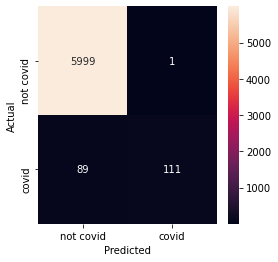

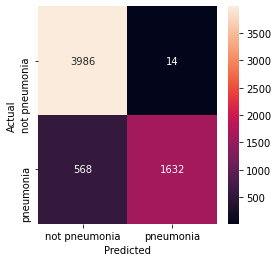

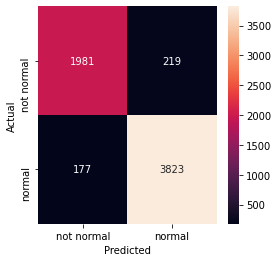

Validation Dataset: 
 Accuracy : 0.91 %
 F1 Score : 0.91 %
 Precesion : 0.91 %
 Recall : 0.91 %


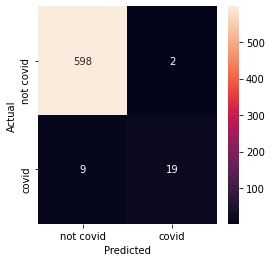

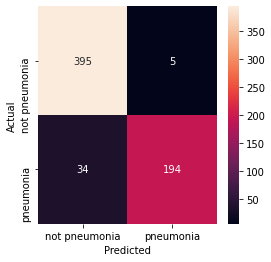

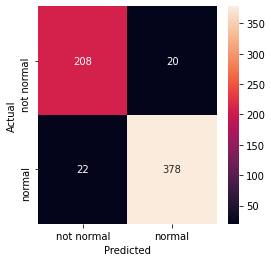

In [0]:
best_model = np.argmax(valid_acc)
r = best_model+1

plt.figure()
plt.plot(np.arange(r), train_loss[:r], 'r', np.arange(r), valid_loss[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
plt.figure()
plt.plot(np.arange(r), train_acc[:r], 'r', np.arange(r), valid_acc[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Acc', 'Validation Acc'])
plt.show()

print(best_model-1, valid_acc[best_model])

weights_path = weights_path = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task2/' + name + '/' + 'ft_' + str(best_model-1) + '.pth'
model.load_state_dict(torch.load(weights_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('loaded')

print('Training Dataset: ')
print_statistics(model, trainloader)
print('Validation Dataset: ')
print_statistics(model, validationloader)

## Task 2 ResNet (Focal Loss)

In [0]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
name = 'resnet18'
out_dir = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task2/' + name
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [0]:
Epochs = 25
criterion = FocalLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [0]:
from tqdm import tqdm


train_loss = np.zeros(Epochs+1)
valid_loss = np.zeros(Epochs+1)

train_acc = np.zeros(Epochs+1)
valid_acc = np.zeros(Epochs+1)

train_acc[0], train_loss[0] = compute_acc_and_loss(model, criterion, trainloader)
valid_acc[0], valid_loss[0] = compute_acc_and_loss(model, criterion, validationloader)

for epoch in range(Epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)] \t\
             Loss:{:.6f}  \
             Acc:{:.2f}   \
             RunningLoss:{:.6f}   \
             RunningAcc:{:.2f}'.format(
             epoch, i * len(inputs), len(trainloader.dataset),
             100. * i / len(trainloader),
             loss.item(),
             acc.item(),
             running_loss,
             running_acc/(i+1)))
    train_acc[epoch+1], train_loss[epoch+1] = compute_acc_and_loss(model, criterion, trainloader)
    valid_acc[epoch+1], valid_loss[epoch+1] = compute_acc_and_loss(model, criterion, validationloader)
    print('Train Epoch: {}  Train Accuracy: {:.2f} Train Loss : {:.6f} \
                            Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            train_acc[epoch+1], train_loss[epoch+1], 
                            valid_acc[epoch+1], valid_loss[epoch+1]))
    torch.save(model.state_dict(), out_dir + '/ft_' + str(epoch) +  '.pth')

print('Finished Training')


### visualize

loaded
Training Dataset: 
 Accuracy : 0.89 %
 F1 Score : 0.89 %
 Precesion : 0.89 %
 Recall : 0.89 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


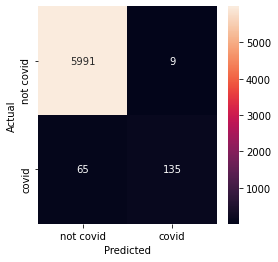

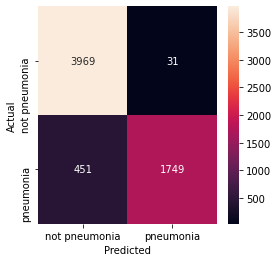

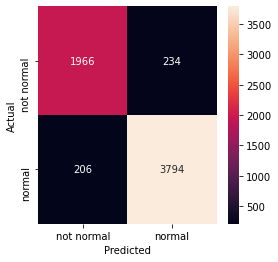

Validation Dataset: 
 Accuracy : 0.93 %
 F1 Score : 0.93 %
 Precesion : 0.93 %
 Recall : 0.93 %


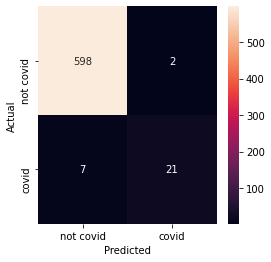

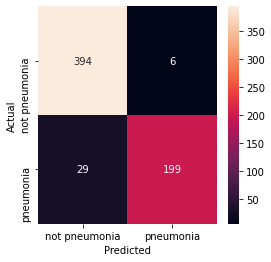

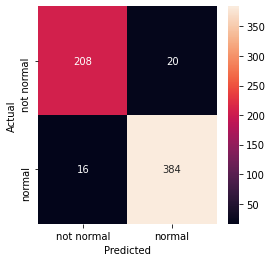

In [0]:
best_model = np.argmax(valid_acc)
r = best_model+1

plt.figure()
plt.plot(np.arange(r), train_loss[:r], 'r', np.arange(r), valid_loss[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
plt.figure()
plt.plot(np.arange(r), train_acc[:r], 'r', np.arange(r), valid_acc[:r], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Acc', 'Validation Acc'])
plt.show()

print(best_model-1, valid_acc[best_model])

weights_path = weights_path = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task2/' + name + '/' + 'ft_' + str(best_model-1) + '.pth'
model.load_state_dict(torch.load(weights_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('loaded')

print('Training Dataset: ')
print_statistics(model, trainloader)
print('Validation Dataset: ')
print_statistics(model, validationloader)

## Test on Test Dataset

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        return original_tuple[0], self.imgs[index] # path

In [0]:
!mkdir './data/A_05_Part_02_Dataset/testset/'
!cp -r './data/A_05_Part_02_Dataset/Test/' './data/A_05_Part_02_Dataset/testset/'

In [0]:
test_data = ImageFolderWithPaths(data_dir + '/testset', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [0]:
weights_path = weights_path = '/content/drive/My Drive/DeepAssignment/Assignment05/part2/models/task2/' + 'resnet18' + '/' + 'ft_' + str(24) + '.pth'
model.load_state_dict(torch.load(weights_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
model.eval()
predic_labels = []
paths = []
ff = open('MSCS19003_results.csv', 'w')
with torch.no_grad():
    for data in testloader:
        images, path = data
        
        images =  images.to(device)
        outputs = model(images)
        outputs = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        name = os.path.split(path[0][0])[1]
        ff.write(name + ',' + str(outputs[0,0]) + ',' + str(outputs[0,1]) + ',' + str(outputs[0,2]) + '\n')

0.png


NameError: ignored